In [1]:
!pip install tensorflow==1.12.0
import tensorflow as tf
print(tf.__version__)

     |████████████████████████████████| 83.1MB 63kB/s 
     |████████████████████████████████| 3.1MB 57.2MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

1.12.0


In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.ndimage.interpolation

In [3]:
learning_rate = 0.0002
batch_size = 32
epochs = 100000
image_dimension = 784
H_dim = 128

In [4]:
def xavier_init(shape):
  return tf.random_normal(shape = shape, stddev = 1./tf.sqrt(shape[0]/2.0))

In [5]:
X_A = tf.placeholder(tf.float32, shape = [None, image_dimension])
X_B = tf.placeholder(tf.float32, shape = [None, image_dimension])

In [6]:
Disc_A_W = {
    "disc_H" : tf.Variable(xavier_init([image_dimension, H_dim])),
    "disc_final" : tf.Variable(xavier_init([H_dim, 1]))
}

Disc_A_Bias = {
    "disc_H" : tf.Variable(xavier_init([H_dim])),
    "disc_final" : tf.Variable(xavier_init([1]))
}


Disc_B_W = {
    "disc_H" : tf.Variable(xavier_init([image_dimension, H_dim])),
    "disc_final" : tf.Variable(xavier_init([H_dim, 1]))
}

Disc_B_Bias = {
    "disc_H" : tf.Variable(xavier_init([H_dim])),
    "disc_final" : tf.Variable(xavier_init([1]))
}


In [7]:
Gen_AB_W = { 
    "Gen_H" : tf.Variable(xavier_init([image_dimension, H_dim])),
    "Gen_final": tf.Variable(xavier_init([H_dim, image_dimension]))
    } 

Gen_AB_Bias = { 
    "Gen_H" : tf.Variable(xavier_init([H_dim])),
    "Gen_final": tf.Variable(xavier_init([image_dimension]))
    }

Gen_BA_W = { 
    "Gen_H" : tf.Variable(xavier_init([image_dimension, H_dim])),
    "Gen_final": tf.Variable(xavier_init([H_dim, image_dimension]))
    }

Gen_BA_Bias = { 
    "Gen_H" : tf.Variable(xavier_init([H_dim])),
    "Gen_final": tf.Variable(xavier_init([image_dimension]))
    }

In [8]:
def Disc_A(x):
  D_hidden_layer = tf.nn.relu(tf.add(tf.matmul(x, Disc_A_W["disc_H"]), Disc_A_Bias["disc_H"]))
  disc_output = (tf.add(tf.matmul(D_hidden_layer, Disc_A_W["disc_final"]), Disc_A_Bias["disc_final"]))
  disc_prob_output = tf.nn.sigmoid(disc_output)
  return disc_prob_output

In [9]:
def Disc_B(x):
  D_hidden_layer = tf.nn.relu(tf.add(tf.matmul(x, Disc_B_W["disc_H"]), Disc_B_Bias["disc_H"]))
  disc_output = (tf.add(tf.matmul(D_hidden_layer, Disc_B_W["disc_final"]), Disc_B_Bias["disc_final"]))
  disc_prob_output = tf.nn.sigmoid(disc_output)
  return disc_prob_output

In [10]:
def GenAB(x):
  G_hidden_layer = tf.nn.relu(tf.add(tf.matmul(x, Gen_AB_W["Gen_H"]), Gen_AB_Bias["Gen_H"]))
  Gen_output = (tf.add(tf.matmul(G_hidden_layer, Gen_AB_W["Gen_final"]), Gen_AB_Bias["Gen_final"]))
  Gen_prob_output = tf.nn.sigmoid(Gen_output)
  return Gen_prob_output

In [11]:
def GenBA(x):
  G_hidden_layer = tf.nn.relu(tf.add(tf.matmul(x, Gen_BA_W["Gen_H"]), Gen_BA_Bias["Gen_H"]))
  Gen_output = (tf.add(tf.matmul(G_hidden_layer, Gen_BA_W["Gen_final"]), Gen_BA_Bias["Gen_final"]))
  Gen_prob_output = tf.nn.sigmoid(Gen_output)
  return Gen_prob_output

In [12]:
#Build the main model forward prop

X_BA = GenBA(X_B)
Disc_A_real = Disc_A(X_A)
Disc_A_fake = Disc_A(X_BA)

X_AB = GenAB(X_A)
Disc_B_real = Disc_B(X_B)
Disc_B_fake = Disc_B(X_AB)

In [13]:
#Used loss functions are not conventional, to ensure a stable training process

Loss_Gen_A = tf.reduce_mean(tf.square(Disc_B_fake - tf.ones_like(Disc_B_fake)))
Loss_Gen_B = tf.reduce_mean(tf.square(Disc_A_fake - tf.ones_like(Disc_A_fake)))
Loss_total = Loss_Gen_A + Loss_Gen_B

In [14]:
X_ABA = GenBA(X_AB)
X_BAB = GenAB(X_BA)

In [15]:
Loss_recon_A = tf.reduce_mean(10 * tf.abs(X_A - X_ABA))
Loss_recon_B = tf.reduce_mean(10 * tf.abs(X_B - X_BAB))
Loss_recon_total = Loss_recon_A + Loss_recon_B

Gen_Loss = Loss_total + Loss_recon_total

In [16]:
Loss_Disc_A = (tf.reduce_mean(tf.square(Disc_A_real - tf.ones_like(Disc_A_real)) + tf.reduce_mean(tf.square(Disc_A_fake))))/2
Loss_Disc_B = (tf.reduce_mean(tf.square(Disc_B_real - tf.ones_like(Disc_B_real)) + tf.reduce_mean(tf.square(Disc_B_fake))))/2

Disc_Loss = Loss_Disc_A + Loss_Disc_B

In [17]:
Disc_param = [Disc_A_W['disc_H'], Disc_A_W["disc_final"], Disc_A_Bias['disc_H'], Disc_A_Bias['disc_final'],
              Disc_B_W['disc_H'], Disc_B_W['disc_final'],Disc_B_Bias['disc_H'], Disc_B_Bias['disc_final'] ]

Gen_param = [Gen_AB_W['Gen_H'], Gen_AB_W["Gen_final"], Gen_AB_Bias['Gen_H'], Gen_AB_Bias['Gen_final'],
            Gen_BA_W['Gen_H'], Gen_BA_W['Gen_final'],Gen_BA_Bias['Gen_H'], Gen_BA_Bias['Gen_final'] ]

In [18]:
Gen_optimizer = tf.train.AdamOptimizer(learning_rate= learning_rate).minimize(Gen_Loss, var_list = Gen_param)
Disc_optimizer = tf.train.AdamOptimizer(learning_rate= learning_rate).minimize(Disc_Loss, var_list = Disc_param)

Download the data required

In [19]:
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz

--2020-09-10 22:25:04--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.72.228
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|52.219.72.228|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26421880 (25M) [binary/octet-stream]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]  25.20M  11.6MB/s    in 2.2s    

2020-09-10 22:25:06 (11.6 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [26421880/26421880]

--2020-09-10 22:25:06--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.47.170
Connecting to fashion-mnist.s3-website.eu-central-1.amaz

In [20]:
!ls

sample_data		   train-images-idx3-ubyte.gz
t10k-images-idx3-ubyte.gz  train-labels-idx1-ubyte.gz
t10k-labels-idx1-ubyte.gz


In [21]:
!pip install -q git+https://github.com/tensorflow/examples.git
!ls

sample_data		   train-images-idx3-ubyte.gz
t10k-images-idx3-ubyte.gz  train-labels-idx1-ubyte.gz
t10k-labels-idx1-ubyte.gz


In [22]:
from tensorflow.examples.tutorials.mnist import input_data

In [23]:
!mkdir MNIST_Fashion
!cp *.gz MNIST_Fashion 

mnist = input_data.read_data_sets("MNIST_Fashion/")

X_train = mnist.train.images
mid = int(X_train.shape[0]/2)

X_train_real = X_train[:mid]

X_train_rot = X_train[mid:].reshape(-1, 28, 28)
X_train_rot = scipy.ndimage.interpolation.rotate(X_train_rot, 90, axes = (1, 2))
X_train_rot = X_train_rot.reshape(-1, 28*28)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_Fashion/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_Fashion/train-labels-idx1-ubyte.gz
Extracting MNIST_Fashion/t10k-images-idx3-ubyte.gz
Extracting MNIST_Fashion/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [24]:
def shuffle_data(x, size):
  start_idx = np.random.randint(0, x.shape[0] - size)
  return x[start_idx : start_idx + size]

In [25]:
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)

for epoch in range(epochs):
  X_A_batch = shuffle_data(X_train_real, batch_size)
  X_B_batch = shuffle_data(X_train_rot, batch_size)

  _, Disc_loss_epoch = sess.run([Disc_optimizer, Disc_Loss], feed_dict = {X_A : X_A_batch, X_B : X_B_batch})
  _, Gen_loss_epoch = sess.run([Gen_optimizer, Gen_Loss], feed_dict = {X_A : X_A_batch, X_B : X_B_batch})

  if epoch % 2000 == 0:
    print("steps: {0}, Disc loss; {1}, Gen Loss: {2}".format(epoch, Disc_loss_epoch, Gen_loss_epoch))  

steps: 0, Disc loss; 0.5669440031051636, Gen Loss: 8.316312789916992
steps: 2000, Disc loss; 0.44690531492233276, Gen Loss: 3.015584945678711
steps: 4000, Disc loss; 0.4065335988998413, Gen Loss: 2.7369472980499268
steps: 6000, Disc loss; 0.3684965968132019, Gen Loss: 2.497702121734619
steps: 8000, Disc loss; 0.4016599655151367, Gen Loss: 2.42861008644104
steps: 10000, Disc loss; 0.4736150801181793, Gen Loss: 2.1916391849517822
steps: 12000, Disc loss; 0.43328261375427246, Gen Loss: 2.2910590171813965
steps: 14000, Disc loss; 0.4204070568084717, Gen Loss: 2.2651548385620117
steps: 16000, Disc loss; 0.4258607029914856, Gen Loss: 2.2735538482666016
steps: 18000, Disc loss; 0.39516884088516235, Gen Loss: 2.3499908447265625
steps: 20000, Disc loss; 0.4094929099082947, Gen Loss: 2.1823251247406006
steps: 22000, Disc loss; 0.41821038722991943, Gen Loss: 2.3180723190307617
steps: 24000, Disc loss; 0.41437816619873047, Gen Loss: 2.270113468170166
steps: 26000, Disc loss; 0.3874194025993347, Ge

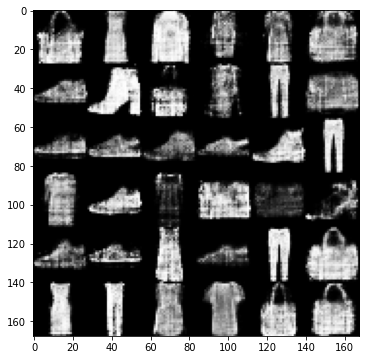

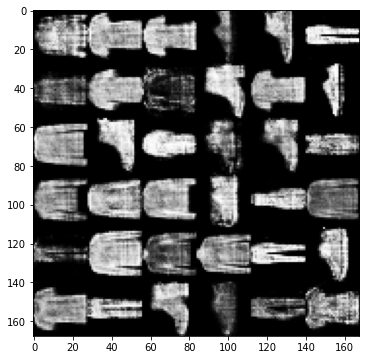

In [26]:
n = 6
canvas1 = np.empty((28 * n, 28 * n))
canvas2 = np.empty((28 * n, 28 * n))

for i in range(n):

  test_A = shuffle_data(X_train_real, batch_size)
  test_B = shuffle_data(X_train_rot, batch_size)

  out_A = sess.run(X_BA, feed_dict = {X_B : test_B})
  out_B = sess.run(X_AB, feed_dict = {X_A : test_A})

  for j in range(n):
    canvas1[i * 28 : (i+1) * 28, j * 28 : (j + 1) * 28] = out_A[j].reshape([28, 28])

  for j in range(n):
    canvas2[i * 28 : (i+1) * 28, j * 28 : (j + 1) * 28] = out_B[j].reshape([28, 28])    

plt.figure(figsize = (n, n))
plt.imshow(canvas1, origin = "upper", cmap = "gray")
plt.show()


plt.figure(figsize = (n, n))
plt.imshow(canvas2, origin = "upper", cmap = "gray")
plt.show()